In [135]:
# math 
import numpy as np
from sklearn.ensemble import RandomForestClassifier
# dataframes
import pandas as pd
import statsmodels.api as sm
# plotting
import matplotlib.pyplot as plt
import seaborn as sns
import random as rand
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.tree import plot_tree
from mlxtend.plotting import plot_decision_regions
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from sklearn.linear_model import LogisticRegression

In [136]:
data = pd.read_csv('compas-scores-two-years.csv')

In [137]:
data.columns

Index(['id', 'name', 'first', 'last', 'compas_screening_date', 'sex', 'dob',
       'age', 'age_cat', 'race', 'juv_fel_count', 'decile_score',
       'juv_misd_count', 'juv_other_count', 'priors_count',
       'days_b_screening_arrest', 'c_jail_in', 'c_jail_out', 'c_case_number',
       'c_offense_date', 'c_arrest_date', 'c_days_from_compas',
       'c_charge_degree', 'c_charge_desc', 'is_recid', 'r_case_number',
       'r_charge_degree', 'r_days_from_arrest', 'r_offense_date',
       'r_charge_desc', 'r_jail_in', 'r_jail_out', 'violent_recid',
       'is_violent_recid', 'vr_case_number', 'vr_charge_degree',
       'vr_offense_date', 'vr_charge_desc', 'type_of_assessment',
       'decile_score.1', 'score_text', 'screening_date',
       'v_type_of_assessment', 'v_decile_score', 'v_score_text',
       'v_screening_date', 'in_custody', 'out_custody', 'priors_count.1',
       'start', 'end', 'event', 'two_year_recid'],
      dtype='object')

In [138]:
len(data)

7214

In [139]:
len(data.drop_duplicates())

7214

In [140]:
data.isna().sum()

id                            0
name                          0
first                         0
last                          0
compas_screening_date         0
sex                           0
dob                           0
age                           0
age_cat                       0
race                          0
juv_fel_count                 0
decile_score                  0
juv_misd_count                0
juv_other_count               0
priors_count                  0
days_b_screening_arrest     307
c_jail_in                   307
c_jail_out                  307
c_case_number                22
c_offense_date             1159
c_arrest_date              6077
c_days_from_compas           22
c_charge_degree               0
c_charge_desc                29
is_recid                      0
r_case_number              3743
r_charge_degree            3743
r_days_from_arrest         4898
r_offense_date             3743
r_charge_desc              3801
r_jail_in                  4898
r_jail_o

# data cleaning and preprocessing 

In [141]:
# only one distinct value, drop
data.v_type_of_assessment.unique()


array(['Risk of Violence'], dtype=object)

In [142]:
# choose one or another
data.score_text.unique()
data.v_score_text.unique()

array(['Low', 'Medium', 'High'], dtype=object)

In [143]:
# could group but perform worse if grouped
data.juv_fel_count.unique()

array([ 0,  2,  1,  8,  4,  3,  9, 20,  6,  5, 10], dtype=int64)

In [144]:
# transform 
data['compas_screening_date'] = pd.to_datetime(data['compas_screening_date'])

In [145]:
# duplicate columns
data=data.drop(columns=['priors_count.1'])

In [146]:
# days between screening and arrest need to be between -30 and 30 for best accuracy of COMPAS Scores
data=data.loc[(data['days_b_screening_arrest']<=30) & (data['days_b_screening_arrest']>=-30)]

# Data visualization

<AxesSubplot:xlabel='age', ylabel='Count'>

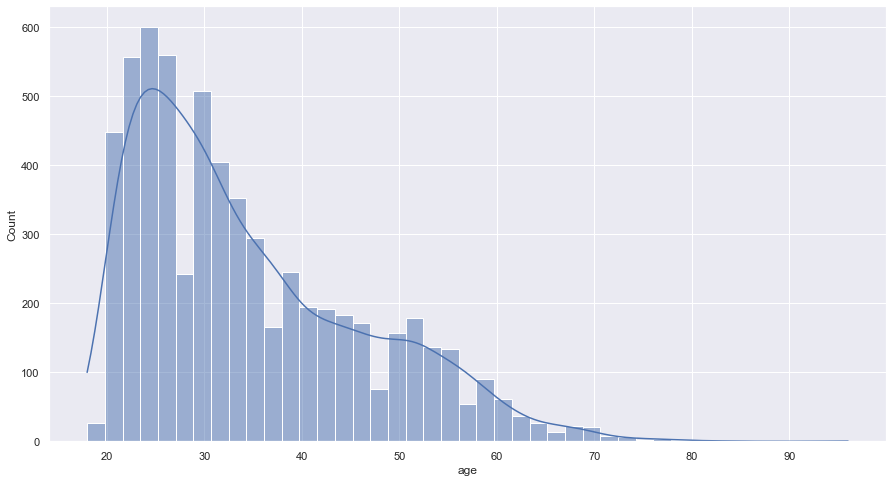

In [147]:
sns.set(rc = {'figure.figsize':(15,8)})
sns.histplot(data.age,kde=True)

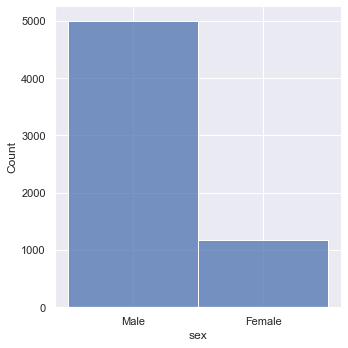

In [148]:
sns.displot(data.sex)

<AxesSubplot:xlabel='compas_screening_date', ylabel='Count'>

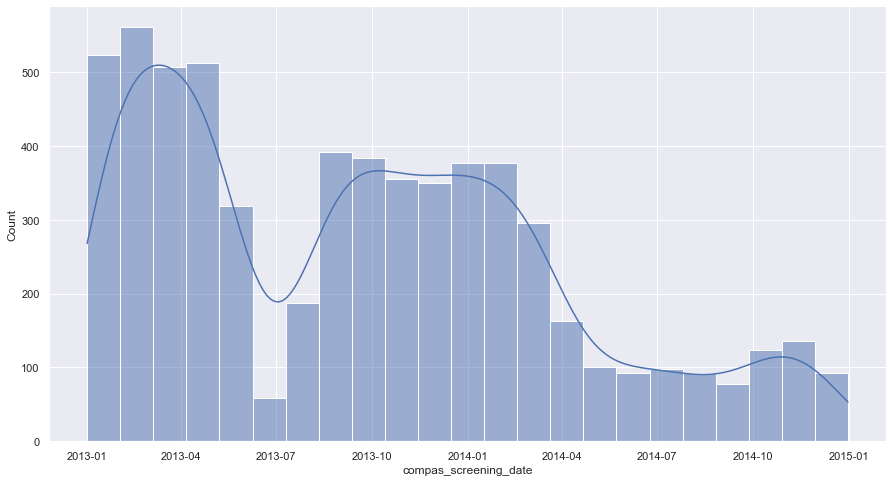

In [149]:
sns.histplot(data.compas_screening_date, kde=True)
# For some reason the compas screening for 2013-07 and after 2014-04 are fewer, we will discover the reason in the future.

[Text(0, 0, 'Other'),
 Text(1, 0, 'African-American'),
 Text(2, 0, 'Caucasian'),
 Text(3, 0, 'Hispanic'),
 Text(4, 0, 'Asian'),
 Text(5, 0, 'Native American')]

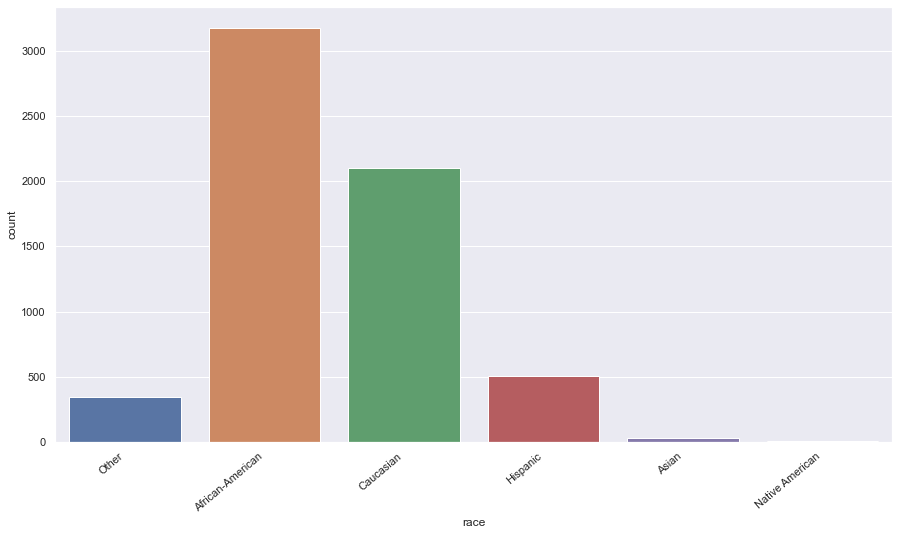

In [150]:
ax = sns.countplot(x="race", data=data)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")

<AxesSubplot:xlabel='is_recid', ylabel='Count'>

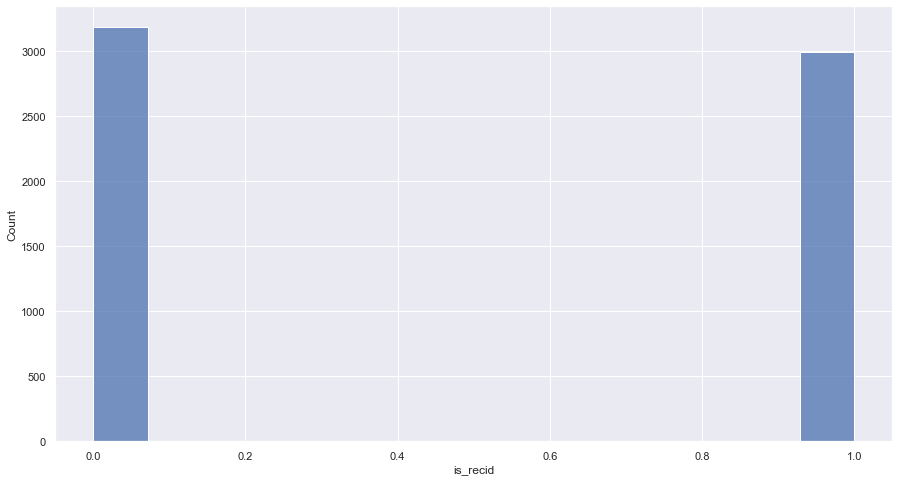

In [153]:
sns.histplot(data.is_recid)

<AxesSubplot:xlabel='priors_count', ylabel='Count'>

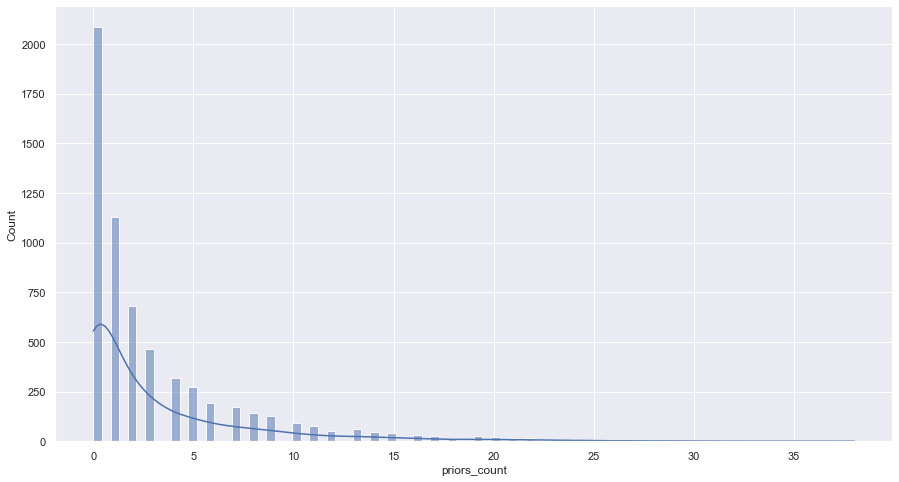

In [159]:
sns.histplot(data.priors_count, kde=True)

<AxesSubplot:xlabel='score_text', ylabel='Count'>

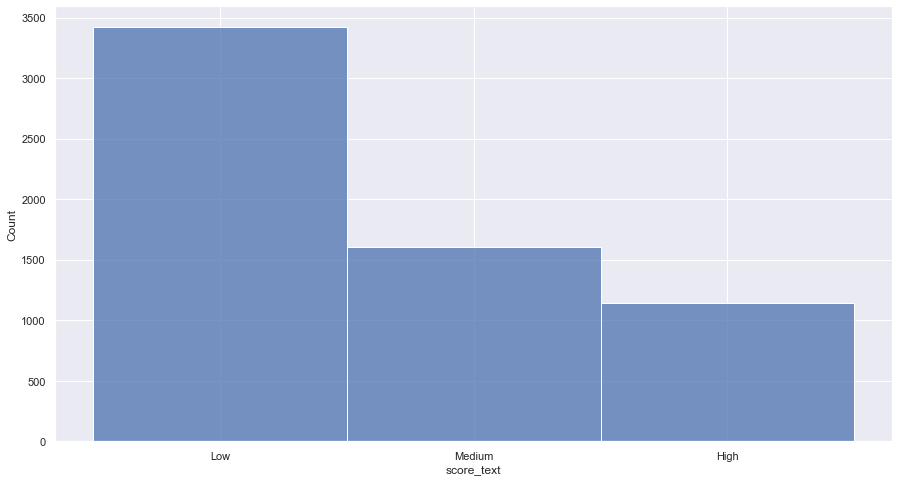

In [160]:
sns.histplot(data.score_text)

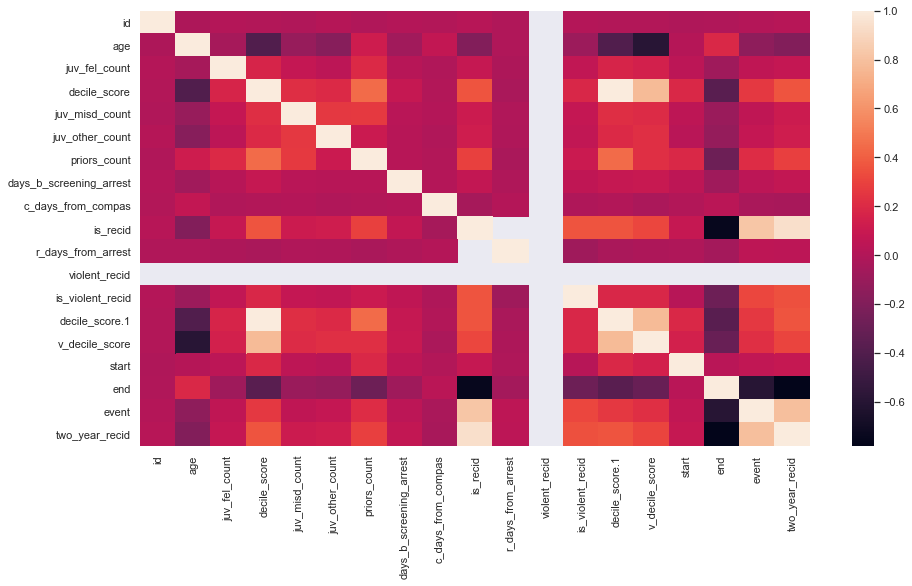

In [161]:
sns.heatmap(data.corr());

# Feature selection and feature engineering

In [162]:
from warnings import filterwarnings
filterwarnings('ignore')

In [163]:
lreg = LogisticRegression()

In [164]:
sfs1 = sfs(lreg, k_features=15, forward=False, verbose=0, scoring='accuracy')
sfs1 = sfs1.fit(data.loc[:, data.columns != 'two_year_recid'], data['two_year_recid'])

In [165]:
feat_names = list(sfs1.k_feature_names_)
print(feat_names)

['id', 'name', 'first', 'last', 'compas_screening_date', 'sex', 'dob', 'age', 'age_cat', 'race', 'juv_fel_count', 'decile_score', 'juv_misd_count', 'juv_other_count', 'priors_count']


In [166]:

features = ['sex','age_cat','race','decile_score','priors_count','c_charge_degree','is_violent_recid','score_text']
features2=['c_charge_degree', 'race', 'age_cat', 'score_text', 'sex', 
                    'days_b_screening_arrest', 'decile_score','priors_count']
labels = ['two_year_recid']
df = data [features + labels]
df2= data[features2 + labels]


In [167]:
df = pd.get_dummies(df)   # hone-hot encoding
df2 = pd.get_dummies(df2)

In [168]:
Y=df['two_year_recid']
X=df.loc[:, df.columns != 'two_year_recid']

In [169]:
X.decile_score.value_counts()

1     1286
2      822
4      666
3      647
5      582
6      529
7      496
8      420
9      420
10     304
Name: decile_score, dtype: int64

In [170]:
#Train and test split
import random
random.seed(101)
df = df.sample(frac = 1, random_state = 42)

X_train, X_val, X_test = np.split(X,[int(.5*len(df)),int(.75*len(df))])
Y_train, Y_val, Y_test = np.split(Y,[int(.5*len(df)),int(.75*len(df))])

In [171]:
X_train

,decile_score,priors_count,is_violent_recid,sex_Female,sex_Male,age_cat_25 - 45,age_cat_Greater than 45,age_cat_Less than 25,race_African-American,race_Asian,race_Caucasian,race_Hispanic,race_Native American,race_Other,c_charge_degree_F,c_charge_degree_M,score_text_High,score_text_Low,score_text_Medium
0,1,0,0,0,1,0,1,0,0,0,0,0,0,1,1,0,0,1,0
1,3,0,1,0,1,1,0,0,1,0,0,0,0,0,1,0,0,1,0
2,4,4,0,0,1,0,0,1,1,0,0,0,0,0,1,0,0,1,0
5,1,0,0,0,1,1,0,0,0,0,0,0,0,1,0,1,0,1,0
6,6,14,0,0,1,1,0,0,0,0,1,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3610,1,1,0,0,1,0,1,0,1,0,0,0,0,0,0,1,0,1,0
3611,4,0,0,0,1,1,0,0,0,0,0,0,0,1,1,0,0,1,0
3612,1,1,0,0,1,1,0,0,0,0,1,0,0,0,0,1,0,1,0
3613,1,0,0,0,1,1,0,0,1,0,0,0,0,0,0,1,0,1,0


# Randomforest

In [172]:
rdc=RandomForestClassifier(n_estimators=100, random_state = 666)


In [173]:
rdc.fit(X_train,Y_train)


RandomForestClassifier(random_state=666)

In [174]:
'''cross_val_score(rdc, X, Y,
                scoring="neg_mean_squared_error", 
                cv=3).mean()
                '''

'cross_val_score(rdc, X, Y,\n                scoring="neg_mean_squared_error", \n                cv=3).mean()\n                '

In [175]:
pred = rdc.predict(X_test)
conf_mat = confusion_matrix(Y_test, pred)
np.sum(pred != Y_test.to_numpy().flatten()) / len(Y_test)

0.3149708360337006

In [176]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
precision = precision_score(Y_test, pred, average='binary')
recall = recall_score(Y_test, pred, average='binary')
accuracy = accuracy_score(Y_test, pred)
print(precision)
print(recall)
print(accuracy)

0.6713615023474179
0.6085106382978723
0.6850291639662994


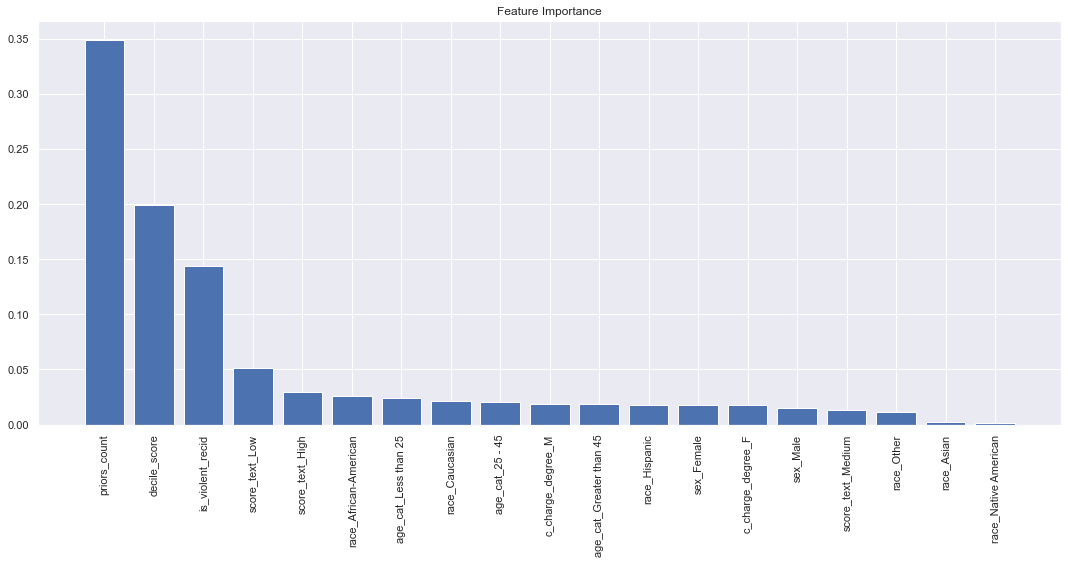

In [177]:
importance = rdc.feature_importances_
sorted_indices = np.argsort(importance)[::-1]
plt.title('Feature Importance')
plt.bar(range(X.shape[1]), importance[sorted_indices], align='center')
plt.xticks(range(X.shape[1]), X.columns[sorted_indices], rotation=90)
plt.tight_layout()
plt.show()

# Random forest with grid search

In [178]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [179]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_val, Y_val)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [180]:
rf_random.best_params_

{'n_estimators': 400,
 'min_samples_split': 10,
 'min_samples_leaf': 4,
 'max_features': 'auto',
 'max_depth': 70,
 'bootstrap': True}

In [181]:
rfc = RandomForestClassifier(n_estimators = 1000,
 min_samples_split= 5,
 min_samples_leaf= 4,
 max_features= 'auto',
 max_depth= 100,
 bootstrap= True)
rfc.fit(X_train,Y_train)

RandomForestClassifier(max_depth=100, min_samples_leaf=4, min_samples_split=5,
                       n_estimators=1000)

In [182]:
pred_rfc = rfc.predict(X_test)
np.sum(pred_rfc != Y_test.to_numpy().flatten()) / len(Y_test)

0.27090084251458196

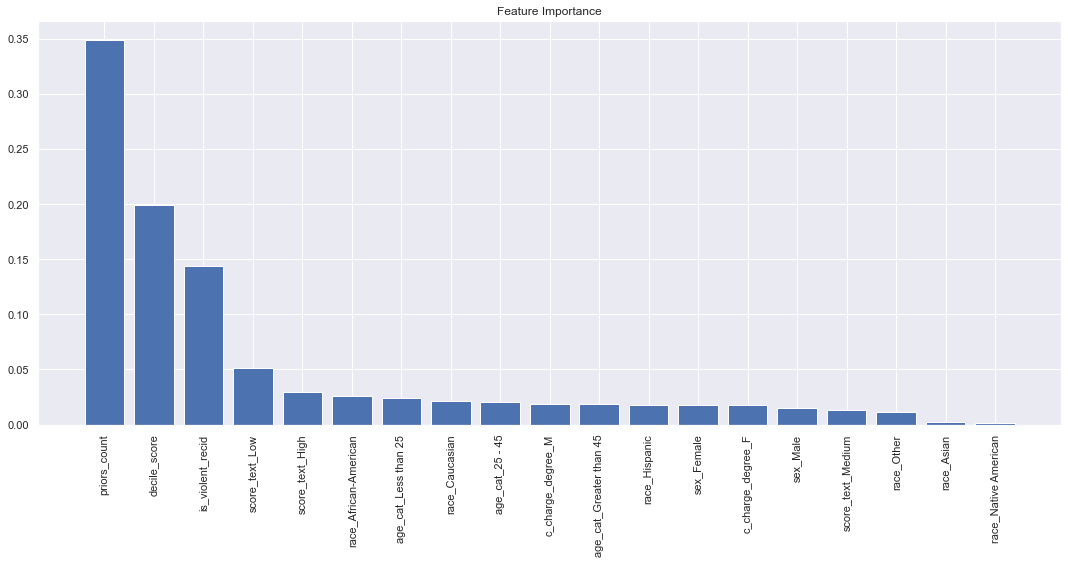

In [183]:
importance = rdc.feature_importances_
sorted_indices = np.argsort(importance)[::-1]
plt.title('Feature Importance')
plt.bar(range(X.shape[1]), importance[sorted_indices], align='center')
plt.xticks(range(X.shape[1]), X.columns[sorted_indices], rotation=90)
plt.tight_layout()
plt.show()

In [184]:
X_test['race_African-American'].value_counts()

1    802
0    741
Name: race_African-American, dtype: int64

In [185]:
X_test1 = X_test.copy()
X_test1['pred']=pred_rfc

In [186]:
len(X_test1[(X_test1['pred']==1) & X_test1['race_African-American']==1])

399

In [187]:
len(X_test1[(X_test1['pred']==1) & X_test1['race_Asian']==1])

2

In [188]:
len(X_test1[(X_test1['pred']==1) & X_test1['race_Caucasian']==1])

141

In [189]:
len(X_test1[(X_test1['pred']==1) & X_test1['race_Hispanic']==1])

36

In [190]:
len(X_test1[(X_test1['pred']==1) & X_test1['race_Native American']==1])

3

In [191]:
len(X_test1[(X_test1['pred']==1) & X_test1['race_Other']==1])

16

In [192]:
len(X_test1[(X_test1['pred']==1) & X_test1['race_Hispanic']==1])

36

In [193]:
X_test1.pred.value_counts()

0    946
1    597
Name: pred, dtype: int64

# Logistic regression and SVC

In [194]:
from sklearn.svm import LinearSVC
from sklearn import metrics

error_SVC = np.zeros(100)

for count,i in enumerate(np.arange(0.01,1.01,0.01)):
    svc_model = LinearSVC(loss = 'hinge', C=i, penalty = 'l2', fit_intercept = True, max_iter = 100000,
                         random_state = 42)
    svc_model.fit(X_train, Y_train)
    pred = svc_model.predict(X_val)
    error_SVC[count] = np.sum(pred!= Y_val.to_numpy().flatten())/len(Y_val)

In [195]:
error_SVC

array([0.29423202, 0.29876863, 0.30330525, 0.30524951, 0.30719378,
       0.30719378, 0.30719378, 0.30719378, 0.30719378, 0.30719378,
       0.30719378, 0.30719378, 0.30719378, 0.30719378, 0.30719378,
       0.30719378, 0.30719378, 0.30719378, 0.30719378, 0.30719378,
       0.30719378, 0.30719378, 0.30719378, 0.30719378, 0.30719378,
       0.30719378, 0.30719378, 0.30719378, 0.30719378, 0.30719378,
       0.30719378, 0.30719378, 0.30719378, 0.30719378, 0.30719378,
       0.30719378, 0.30719378, 0.30719378, 0.30719378, 0.30719378,
       0.30719378, 0.30719378, 0.30719378, 0.30719378, 0.30719378,
       0.30719378, 0.30719378, 0.30719378, 0.30719378, 0.30719378,
       0.30719378, 0.30719378, 0.30719378, 0.30719378, 0.30719378,
       0.30719378, 0.30719378, 0.30719378, 0.30719378, 0.30719378,
       0.30719378, 0.30719378, 0.30719378, 0.30719378, 0.30719378,
       0.30719378, 0.30719378, 0.30719378, 0.30719378, 0.30719378,
       0.30719378, 0.30719378, 0.30719378, 0.30719378, 0.30719

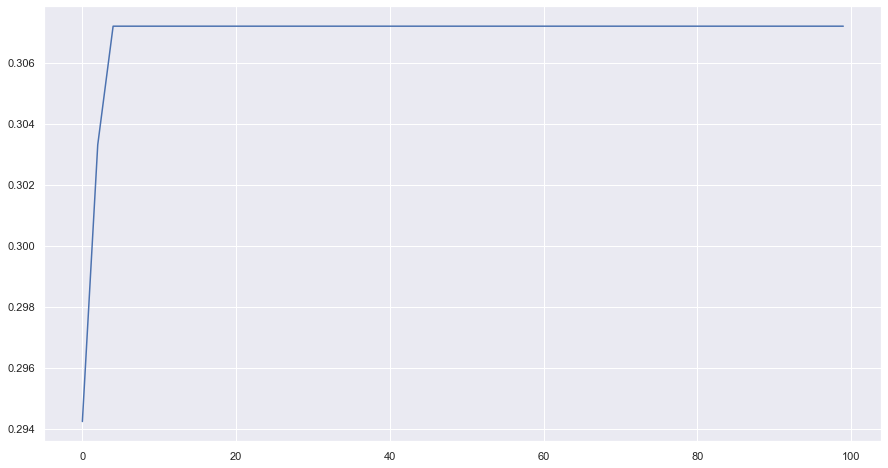

In [196]:
plt.plot(error_SVC)

In [197]:
np.argwhere(error_SVC == min(error_SVC))

array([[0]], dtype=int64)

In [198]:
svc_model = LinearSVC(loss = 'hinge', C=0.01, penalty = 'l2', fit_intercept = True, max_iter = 100000,
                         random_state = 42)

In [199]:
svc_model.fit(X_train,Y_train)
pred_svc = svc_model.predict(X_test)
np.sum(pred_svc != Y_test.to_numpy().flatten()) / len(Y_test)

0.29747245625405055

In [200]:
X_test

,decile_score,priors_count,is_violent_recid,sex_Female,sex_Male,age_cat_25 - 45,age_cat_Greater than 45,age_cat_Less than 25,race_African-American,race_Asian,race_Caucasian,race_Hispanic,race_Native American,race_Other,c_charge_degree_F,c_charge_degree_M,score_text_High,score_text_Low,score_text_Medium
5399,6,3,0,0,1,1,0,0,0,0,1,0,0,0,1,0,0,0,1
5400,3,2,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,1,0
5401,1,6,0,0,1,1,0,0,1,0,0,0,0,0,1,0,0,1,0
5402,6,6,1,1,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1
5403,9,5,0,0,1,0,0,1,1,0,0,0,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7209,7,0,0,0,1,0,0,1,1,0,0,0,0,0,1,0,0,0,1
7210,3,0,0,0,1,0,0,1,1,0,0,0,0,0,1,0,0,1,0
7211,1,0,0,0,1,0,1,0,0,0,0,0,0,1,1,0,0,1,0
7212,2,3,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,1,0


In [201]:
svc_model.coef_

array([[ 0.06384658,  0.06371766,  1.03398931, -0.18245875, -0.04014783,
        -0.12830722, -0.14279692,  0.04849756, -0.05077899, -0.01      ,
        -0.06552785, -0.05      , -0.03      , -0.01629975, -0.10399383,
        -0.11861276,  0.41227436, -0.61620858, -0.01867236]])

In [202]:
from sklearn.linear_model import LogisticRegression

error_LR = np.zeros(100)

for count,i in enumerate(np.arange(0.01,1.01,0.01)):
    LR_model = LogisticRegression( C=i, penalty = 'l2', fit_intercept = True, max_iter = 100000,
                         random_state = 42)
    LR_model.fit(X_train, Y_train)
    pred = LR_model.predict(X_val)
    error_LR[count] = np.sum(pred!= Y_val.to_numpy().flatten())/len(Y_val)

In [203]:
error_LR[4]

0.2832145171743357

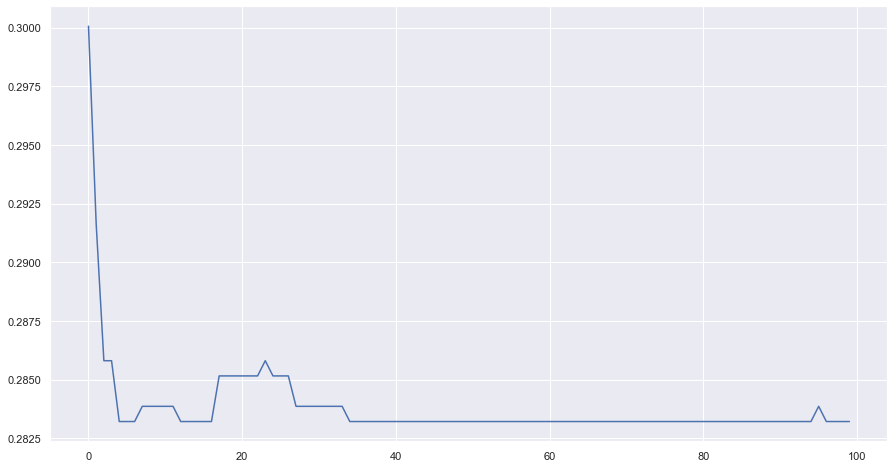

In [204]:
plt.plot(error_LR)

In [205]:
np.argwhere(error_LR == min(error_LR))

array([[ 4],
       [ 5],
       [ 6],
       [12],
       [13],
       [14],
       [15],
       [16],
       [34],
       [35],
       [36],
       [37],
       [38],
       [39],
       [40],
       [41],
       [42],
       [43],
       [44],
       [45],
       [46],
       [47],
       [48],
       [49],
       [50],
       [51],
       [52],
       [53],
       [54],
       [55],
       [56],
       [57],
       [58],
       [59],
       [60],
       [61],
       [62],
       [63],
       [64],
       [65],
       [66],
       [67],
       [68],
       [69],
       [70],
       [71],
       [72],
       [73],
       [74],
       [75],
       [76],
       [77],
       [78],
       [79],
       [80],
       [81],
       [82],
       [83],
       [84],
       [85],
       [86],
       [87],
       [88],
       [89],
       [90],
       [91],
       [92],
       [93],
       [94],
       [96],
       [97],
       [98],
       [99]], dtype=int64)

In [206]:
LR_model = LogisticRegression( C=0.04, penalty = 'l2', fit_intercept = True, max_iter = 100000,
                         random_state = 42)

In [207]:
LR_model.fit(X_train,Y_train)
pred_lr = LR_model.predict(X_test)
np.sum(pred_lr != Y_test.to_numpy().flatten()) / len(Y_test)

0.28062216461438755

In [208]:
LR_model.coef_

array([[ 0.14910977,  0.0994518 ,  1.65127375, -0.18504975,  0.18525785,
        -0.04686964, -0.27543099,  0.32250874,  0.05229532,  0.01070303,
         0.06515896, -0.0479318 , -0.07584421, -0.00417319,  0.07999373,
        -0.07978562,  0.02761876, -0.06310255,  0.03569189]])

# Model evaluation 

In [209]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
#random forest
precision = precision_score(Y_test, pred_rfc, average='binary')
recall = recall_score(Y_test, pred_rfc, average='binary')
accuracy = accuracy_score(Y_test, pred_rfc)
f1 = f1_score(Y_test, pred_rfc, average='binary')
print(precision)
print(recall)
print(f1)
print(accuracy)

0.7403685092127303
0.6269503546099291
0.6789554531490015
0.729099157485418


In [210]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(Y_test, pred_rfc)
print(conf_mat)

[[683 155]
 [263 442]]


In [211]:
#linearSVC
precision = precision_score(Y_test, pred_svc, average='binary')
recall = recall_score(Y_test, pred_svc, average='binary')
accuracy = accuracy_score(Y_test, pred_svc)
f1 = f1_score(Y_test, pred_svc, average='binary')
print(precision)
print(recall)
print(f1)
print(accuracy)

0.7173144876325088
0.5758865248226951
0.6388670338316287
0.7025275437459495


In [212]:
#logistic regression
precision = precision_score(Y_test, pred_lr, average='binary')
recall = recall_score(Y_test, pred_lr, average='binary')
accuracy = accuracy_score(Y_test, pred_lr)
f1 = f1_score(Y_test, pred_lr, average='binary')
print(precision)
print(recall)
print(f1)
print(accuracy)

0.7361111111111112
0.601418439716312
0.6619828259172522
0.7193778353856124
